We will choose DelayMatchSample and GoNogo from neurogym to assess our models

In [1]:
# IMPORTS AND SETUPS
import torch
import random
import neurogym as ngym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# ignore gym warnings
warnings.filterwarnings('ignore', module='gymnasium')

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use GPU
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

TASKS = [
    'DelayMatchSample-v0',
    'GoNogo-v0',
]

# inspect our tasks
for task in TASKS:
    dt = 20 # the dt we want to train with
    env = ngym.make(task, dt=dt)
    dataset = ngym.Dataset(env, batch_size=1, seq_len=1000)
    _, labels = dataset()
    print(f"{task}:")
    print(f"  Timing (ms): {env.timing}")
    print(f"  Total time per trial: {sum(env.timing.values())}")
    print(f"  Total steps per trial: {sum(env.timing.values())/dt}")
    print(f"  Decision labels (!=0): {(labels != 0).sum()} / {labels.size}")
    print(f"  Unique labels: {np.unique(labels)}")
    print(f"  Actions: {env.action_space.n}\n")

DelayMatchSample-v0:
  Timing (ms): {'fixation': 300, 'sample': 500, 'delay': 1000, 'test': 500, 'decision': 900}
  Total time per trial: 3200
  Total steps per trial: 160.0
  Decision labels (!=0): 270 / 1000
  Unique labels: [0 1 2]
  Actions: 3

GoNogo-v0:
  Timing (ms): {'fixation': 0, 'stimulus': 500, 'delay': 500, 'decision': 500}
  Total time per trial: 1500
  Total steps per trial: 75.0
  Decision labels (!=0): 175 / 1000
  Unique labels: [0 1]
  Actions: 2



In [2]:
# IMPORT CODE and CONFIGS
from src.experiment import Experiment
import config as cfg

### 2a - Delay Match Sample - RNN vs Sparse-Dale-RNN


TRAINING >>>>>>>>>>>>> vanilla

Building <class 'src.rnn_vanilla.RNNVanilla'> model with hidden size 128
Input size: 3, Output size: 3 
[vanilla] Epoch 0: Loss=1.0816, Acc=0.0000
[vanilla] Epoch 10: Loss=0.7784, Acc=0.0000
[vanilla] Epoch 20: Loss=0.6192, Acc=0.0000
[vanilla] Epoch 30: Loss=0.5225, Acc=0.0000
[vanilla] Epoch 40: Loss=0.4234, Acc=0.3019
[vanilla] Epoch 50: Loss=0.3288, Acc=0.3870
[vanilla] Epoch 60: Loss=0.2835, Acc=0.3965
[vanilla] Epoch 70: Loss=0.2614, Acc=0.4745
[vanilla] Epoch 80: Loss=0.2529, Acc=0.4977
[vanilla] Epoch 90: Loss=0.2534, Acc=0.4417
[vanilla] Epoch 100: Loss=0.2483, Acc=0.4387
[vanilla] Epoch 110: Loss=0.2463, Acc=0.4498
[vanilla] Epoch 120: Loss=0.2427, Acc=0.4898
[vanilla] Epoch 130: Loss=0.2407, Acc=0.4896
[vanilla] Epoch 140: Loss=0.2373, Acc=0.4757
[vanilla] Epoch 150: Loss=0.2341, Acc=0.5433
[vanilla] Epoch 160: Loss=0.2644, Acc=0.4486
[vanilla] Epoch 170: Loss=0.2444, Acc=0.5056
[vanilla] Epoch 180: Loss=0.2349, Acc=0.4657
[vanilla] Epoch 190

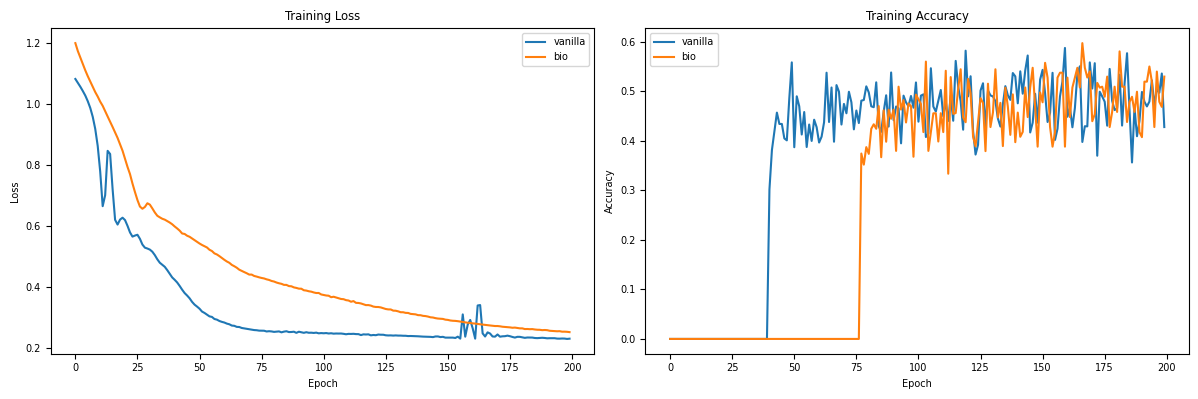

In [3]:
dms = Experiment(TASKS[0], dt=cfg.DT, device=cfg.DEVICE) \
    .compare(
        models_configs=[cfg.RNN_VANILLA, cfg.RNN_BIO], 
        train_configs=cfg.DMS_TRAINING_CONFIGS
    ) \
    .summary() \
    .plot()

### 2b - Models Comparison

In [4]:
def plot_hidden_comparison(experiment, r_excitatory=0.8):
    """Compare final hidden states across all models."""
    model_names = list(experiment.hidden_hist.keys())
    n_models = len(model_names)
    
    fig, axes = plt.subplots(2, n_models, figsize=(5 * n_models, 6))
    
    if n_models == 1:
        axes = axes.reshape(-1, 1)
    
    for i, name in enumerate(model_names):
        # get final epoch
        epochs = sorted(experiment.hidden_hist[name].keys())
        h = experiment.hidden_hist[name][epochs[-1]]  # (seq_len, hidden_size)
        
        # row 1 heatmap
        axes[0, i].imshow(h.T, aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1)
        axes[0, i].set_xlabel('Time')
        axes[0, i].set_ylabel('Neuron')
        axes[0, i].set_title(f'{name}')
        
        if 'bio' in name.lower() and r_excitatory is not None:
            n_exc = int(h.shape[1] * r_excitatory)
            axes[0, i].axhline(y=n_exc - 0.5, color='black', linestyle='--')
        
        # row 2 mean activation over time
        if 'bio' in name.lower() and r_excitatory is not None:
            n_exc = int(h.shape[1] * r_excitatory)
            axes[1, i].plot(h[:, :n_exc].mean(axis=1), label='Excitatory', color='blue')
            axes[1, i].plot(h[:, n_exc:].mean(axis=1), label='Inhibitory', color='red')
            axes[1, i].legend()
        else:
            axes[1, i].plot(h.mean(axis=1), color='blue')
        axes[1, i].set_xlabel('Time')
        axes[1, i].set_ylabel('Mean activation')
    
    plt.tight_layout()
    plt.show()

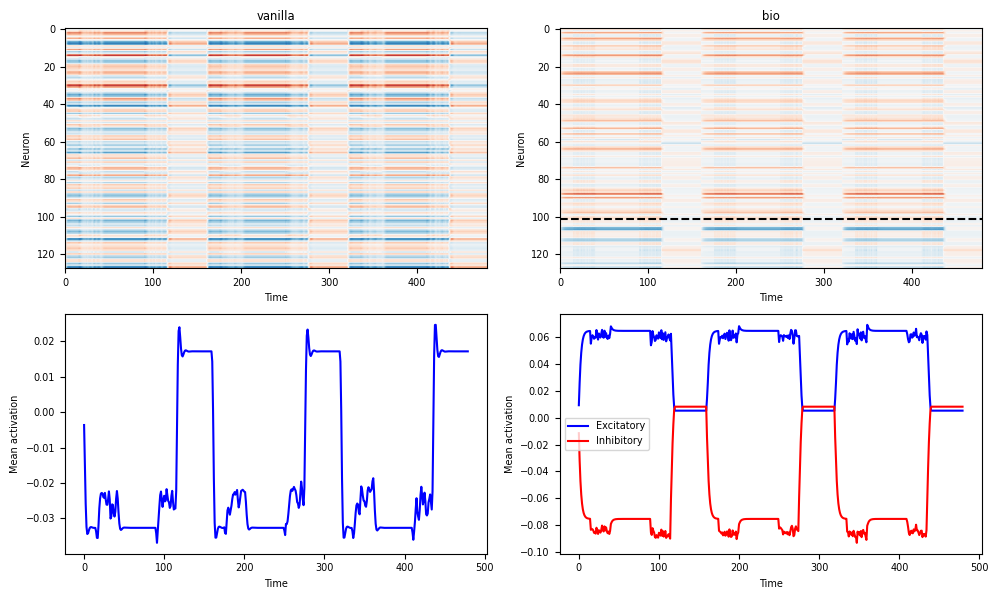

In [5]:
plot_hidden_comparison(dms, r_excitatory=0.8)

### 2c - GoNogo


TRAINING >>>>>>>>>>>>> vanilla

Building <class 'src.rnn_vanilla.RNNVanilla'> model with hidden size 128
Input size: 3, Output size: 2 
[vanilla] Epoch 0: Loss=0.6475, Acc=0.0000
[vanilla] Epoch 10: Loss=0.4384, Acc=0.0000
[vanilla] Epoch 20: Loss=0.3742, Acc=0.0000
[vanilla] Epoch 30: Loss=0.3376, Acc=0.0000
[vanilla] Epoch 40: Loss=0.3081, Acc=0.0000
[vanilla] Epoch 50: Loss=0.2699, Acc=0.0000
[vanilla] Epoch 60: Loss=0.2622, Acc=0.1600
[vanilla] Epoch 70: Loss=0.2644, Acc=0.6800
[vanilla] Epoch 80: Loss=0.2619, Acc=0.6400
[vanilla] Epoch 90: Loss=0.2566, Acc=0.2000
[vanilla] Epoch 100: Loss=0.2618, Acc=0.2000
[vanilla] Epoch 110: Loss=0.2578, Acc=0.1600
[vanilla] Epoch 120: Loss=0.2527, Acc=0.6400
[vanilla] Epoch 130: Loss=0.2540, Acc=0.2800
[vanilla] Epoch 140: Loss=0.2563, Acc=0.1200
[vanilla] Epoch 150: Loss=0.2510, Acc=0.1200
[vanilla] Epoch 160: Loss=0.2421, Acc=0.0800
[vanilla] Epoch 170: Loss=0.2469, Acc=0.2400
[vanilla] Epoch 180: Loss=0.2478, Acc=0.7600
[vanilla] Epoch 190

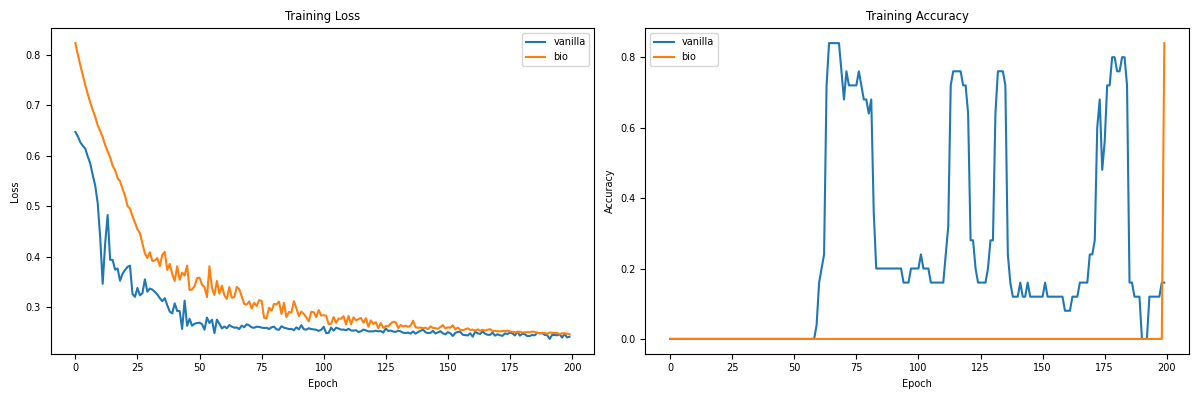

In [6]:
gng = Experiment(TASKS[1], dt=cfg.DT, device=cfg.DEVICE) \
    .compare(
        models_configs=[cfg.RNN_VANILLA, cfg.RNN_BIO], 
        train_configs=cfg.GNG_TRAINING_CONFIGS
    ) \
    .summary() \
    .plot()

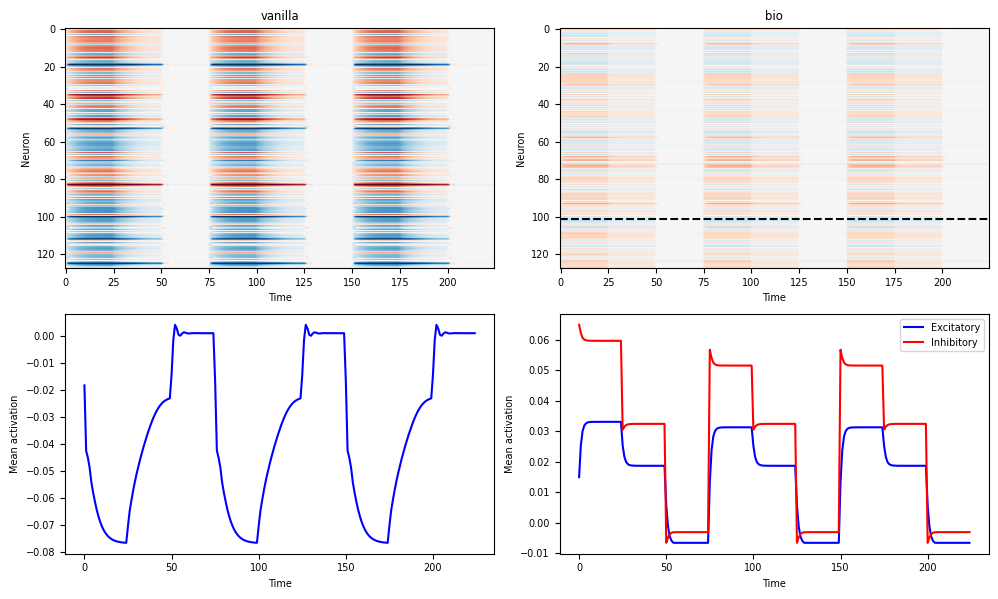

In [7]:
plot_hidden_comparison(gng, r_excitatory=0.8)

In [8]:
# separately test trained models from experiment on fresh data gen
def test_models(experiment, num_trials, is_print=False):
    """Test all trained models on fresh trials."""
    env = ngym.make(experiment.env_name, dt=experiment.dt)

    trial_time = sum(env.timing.values())
    steps_per_trial = int(trial_time/dt)
    seq_len = steps_per_trial * num_trials
    
    dataset = ngym.Dataset(env, batch_size=1, seq_len=seq_len)
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).float().to(experiment.device)
    labels = torch.from_numpy(labels).long().to(experiment.device)
    
    if is_print:
        print(f"Testing on {num_trials} {experiment.env_name} trials ({seq_len} steps)\n")
    
    res = {}
    for name, model in experiment.models.items():
        model.eval()
        
        with torch.no_grad():
            outputs, _ = model(inputs)
            preds = outputs.argmax(dim=-1)
            
            mask = labels != 0
            if mask.sum() > 0:
                acc = (preds[mask] == labels[mask]).float().mean().item()
            else:
                acc = 0.0
        res[name] = round(acc, 4)
    return res

In [9]:
# test multiple times
runs = 20
results = []
for r in range(runs):
    results.append(test_models(gng, 3))
# show test accuracy distribution
res_df = pd.DataFrame(results)
res_df.describe()

,vanilla,bio
count,20.000000,20.00000
mean,0.152000,0.79800
std,0.035777,0.18783
min,0.000000,0.00000
25%,0.160000,0.84000
50%,0.160000,0.84000
75%,0.160000,0.84000
max,0.160000,0.84000
